In [42]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
import copy
import pickle
import os
import itertools
import glob
from math import sqrt
from scipy.ndimage import gaussian_filter1d

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector
from tensorflow.keras.layers import Dense, Flatten, Reshape, Dropout, TimeDistributed
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterSampler, TimeSeriesSplit

seed = 123
tf.keras.utils.set_random_seed(seed)

In [43]:
%run utils.ipynb

In [44]:
%run preprocessing.ipynb

In [45]:
%run preparation.ipynb

In [46]:
%run training_lstm.ipynb

In [47]:
%run training_dense.ipynb

In [48]:
%run predict.ipynb

# Loading data

In [49]:
model_name = 'dense'

In [50]:
data_path = 'datasets/raw/sf_normal_final_indicators_93600.csv'
df = pd.read_csv(data_path)
df = df.drop('timestamp', axis = 1)
number_of_features = len(df.columns)

# Preprocessing

In [51]:
if model_name == 'lstm':
    diff = 1
else:
    diff = 0

In [52]:
params = [
    [], # columns to drop
    False, # ratio
    False, # smoothing
    False, # collinearity
    False, # log
    300, # aggregation
    False, # statistics
    diff, # differencing
    False, # seasonality
    True # normalize
]

df_ = copy.deepcopy(df)

df_proc, scaler = preprocessing(df_,
                        columns_to_remove = params[0],
                        ratio = params[1],
                        smoothing = params[2],
                        collinearity = params[3],
                        log = params[4],
                        aggregation = params[5],
                        statistics = params[6],
                        differencing = params[7],
                        seasonality = params[8],
                        normalize = params[9],
                        load_scaler = False,
                        save = False)

scaler_path = f"df_{params[0]}_{params[1]}_{params[2]}_{params[3]}_{params[4]}_{params[5]}_{params[6]}_{params[7]}_{params[8]}_{params[9]}_scaler.pkl"

(86400, 39)


# Cross-Validation

In [53]:
# Define the hyperparameter search space
param_grid = {
    'n_layers_encoder': [1, 2],
    'n_layers_decoder': [1, 2],
    'hidden_units': [[128, 64, 64, 128], [64, 32, 32, 64], [128, 64, 32, 32, 64, 128], [64, 32, 16, 16, 32, 64]],
    'activation_hidden': ['relu', 'tanh'],
    'activation_dense': ['sigmoid', 'relu'],
    'dropout_rate': [0, 0.2, 0.4],
    'learning_rate': [0.001, 0.0001],
    'batch_size': [16, 32, 64]
}

In [54]:
def rolling_cross_validation(df, initial_train_size, horizon, window_size, param_grid, model_name, n_iter = 50):
    results = {}
    fold_number = 0
    max_possible_index = len(df) - horizon + 1
    
    for start_index in range(initial_train_size, max_possible_index, horizon):
        fold_scores = []
        train = df.iloc[:start_index]
        val = df.iloc[start_index:start_index + horizon]
        if model_name == 'lstm':
            train_set = create_sequences(train, window_size, 0)
            val_set = create_sequences(val, window_size, 0)
        else:
            train_set = train
            val_set = val
        
        print(f"Train period: 0 to {start_index}, Test period: {start_index} to {start_index + horizon}")
              
        for params in ParameterSampler(param_grid, n_iter):
            if (params['n_layers_encoder'] == 1 and params['n_layers_decoder'] == 1 and len(params['hidden_units']) == 4) or (params['n_layers_encoder'] == 2 and params['n_layers_decoder'] == 2 and len(params['hidden_units']) == 6):
                if model_name == 'lstm':
                    history, model = training_lstm(train_set,
                                           val_set,
                                           n_layers_encoder = params['n_layers_encoder'],
                                           n_layers_decoder = params['n_layers_decoder'],
                                           hidden_units = params['hidden_units'],
                                           activation_hidden = params['activation_hidden'],
                                           activation_dense = params['activation_dense'],
                                           dropout_rate = params['dropout_rate'],
                                           learning_rate = params['learning_rate'],
                                           n_epochs = 500,
                                           metric = 'mae',
                                           batch_size = params['batch_size'],
                                           window_size = window_size,
                                           plot = False,
                                           save = False)
                    fold_scores.append((params, np.min(history.history['val_loss'])))
                else:
                    history, model = training_dense(train_set,
                                           val_set,
                                           n_layers_encoder = params['n_layers_encoder'],
                                           n_layers_decoder = params['n_layers_decoder'],
                                           hidden_units = params['hidden_units'],
                                           activation_hidden = params['activation_hidden'],
                                           activation_dense = params['activation_dense'],
                                           dropout_rate = params['dropout_rate'],
                                           learning_rate = params['learning_rate'],
                                           n_epochs = 500,
                                           metric = 'mae',
                                           batch_size = params['batch_size'],
                                           plot = False,
                                           save = False)
                    fold_scores.append((params, np.min(history.history['val_loss'])))
        
        top_scores = sorted(fold_scores, key = lambda x: x[1])[:10]
        results[f"Top 10 scores on fold {fold_number + 1}"] = ["{}: {:.4f}".format(str(params), score) for params, score in top_scores]
        fold_number += 1
        
    results_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in results.items()]))
    results_df.to_csv('cross_validation/model_performance_w_size_' + str(window_size) + '.csv', index=False)
    print('Results saved to model_performance_w_size_' + str(window_size) + '.csv')

In [ ]:
if model_name == 'lstm':
    window_size = [10, 20, 50, 100]
    for window in window_size:
        rolling_cross_validation(df_proc, 36000, 12600, window, param_grid, model_name, n_iter = 50)
else:
    window = 0
    rolling_cross_validation(df_proc, 36000, 12600, window, param_grid, model_name, n_iter = 50)

# CV image

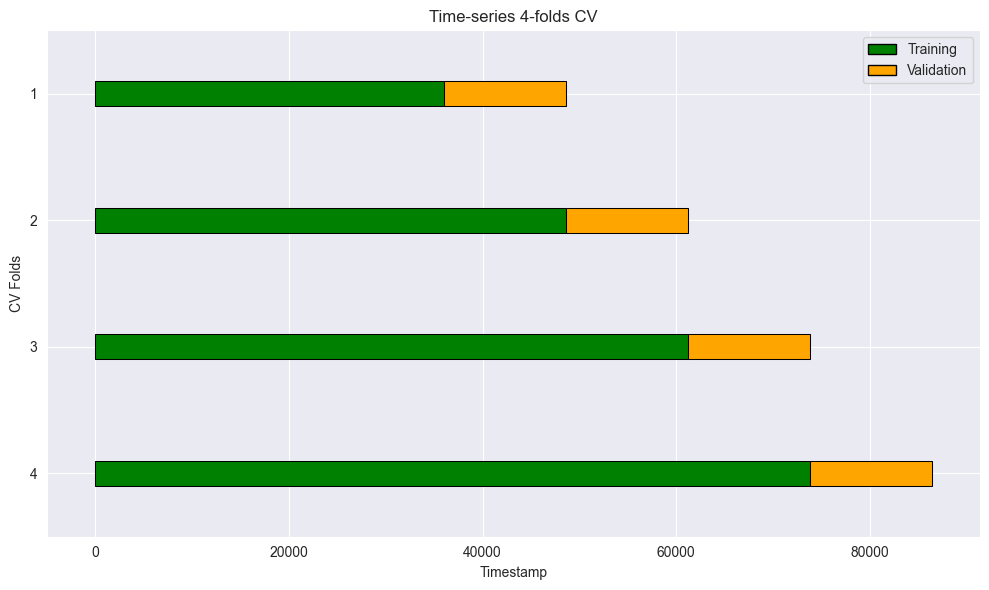

In [108]:
fig, ax = plt.subplots(figsize = (10, 6))

ax.add_patch(plt.Rectangle((0, 4 - 0.1), 36000, 0.2, facecolor = 'green', edgecolor = 'black', linewidth = 0.75, label = 'Training'))
ax.add_patch(plt.Rectangle((36000, 4 - 0.1), 12600, 0.2, facecolor = 'orange', edgecolor = 'black', linewidth = 0.75, label = 'Validation'))
ax.add_patch(plt.Rectangle((0, 3 - 0.1), 48600, 0.2, facecolor = 'green', edgecolor = 'black', linewidth = 0.75, label = 'Training'))
ax.add_patch(plt.Rectangle((48600, 3 - 0.1), 12600, 0.2, facecolor = 'orange', edgecolor = 'black', linewidth = 0.75, label = 'Validation'))
ax.add_patch(plt.Rectangle((0, 2 - 0.1), 61200, 0.2, facecolor = 'green', edgecolor = 'black', linewidth = 0.75, label = 'Training'))
ax.add_patch(plt.Rectangle((61200, 2 - 0.1), 12600, 0.2, facecolor = 'orange', edgecolor = 'black', linewidth = 0.75, label = 'Validation'))
ax.add_patch(plt.Rectangle((0, 1 - 0.1), 73800, 0.2, facecolor = 'green', edgecolor = 'black', linewidth = 0.75, label = 'Training'))
ax.add_patch(plt.Rectangle((73800, 1 - 0.1), 12600, 0.2, facecolor = 'orange', edgecolor = 'black', linewidth = 0.75, label = 'Validation'))

ax.set_yticks(np.arange(1, 5))
ax.set_yticklabels(["4", "3", "2", "1"])
ax.set_xlabel("Timestamp")
ax.set_ylabel("CV Folds")
ax.set_title("Time-series 4-folds CV")
ax.set_xlim(-5000, 91400)  # Adding some space by adjusting limits beyond the data range
ax.set_ylim(0.5, 4.5)
plt.legend(handles = [plt.Rectangle((0,0),1,1, color = c, ec = "k") for c in ['green', 'orange']], labels = ['Training', 'Validation'])
plt.tight_layout()

adjusted_plot_path = 'cross_validation/time_series_cv.png'
plt.savefig(adjusted_plot_path, dpi = 300)
plt.show()